<a href="https://colab.research.google.com/github/Ujjwal10228/GSoC-2025/blob/main/QML_for_HEP_GSoC_Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Implementation of IQGAN on LHC data for Background estimation**

We generate new observables for a particle that fails the identi cation criteria, so that it can mimic a misidentied object whose observables retain correlations with other event observables.

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 547.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 1.2 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import matplotlib.pyplot as plt
import math
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse

from scipy import misc
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import os
from sklearn.decomposition import PCA
import numpy as np
import torchvision
from skimage import io
import torchvision.datasets.mnist as mnist
from PIL import Image

In [3]:
# Configuration
BATCH_SIZE = 32
epochs = 100
lr = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Load dataset
file_path = ("/content/drive/MyDrive/Datasets/QIS_EXAM_200Events.npz")  # Replace with actual path
data = np.load(file_path, allow_pickle=True)

print(data.files)

# Extract training and test data
train_data_dict = data['training_input'].item()
test_data_dict = data['test_input'].item()

X_label1 = train_data_dict['1']
Z_label0 = train_data_dict['0']

# Stored last column in Y_real
Y_real = Z_label0[:,-1]

# Dropped last columns
Z_label0 = Z_label0[:, :-1]
# Z_label0


X_train = X_label1
Y_real = Y_real.reshape(-1, 1)
Z_train = Z_label0


['training_input', 'test_input']


In [5]:
Y_real[:5], Z_train[:5], X_train[:5]

(array([[-0.56900862],
        [-0.54463516],
        [-0.58329176],
        [-0.49963115],
        [-0.5149399 ]]),
 array([[-0.43079088,  0.86834819, -0.92614721, -0.92662029],
        [ 0.33924198,  0.56155499,  0.93097459, -0.91631726],
        [-0.42888879,  0.87064961, -0.92782179, -0.77533991],
        [-0.43262871,  0.86128919, -0.92240878, -0.88048862],
        [-0.99925345, -0.99949586,  0.07753685, -0.84218034]]),
 array([[-0.42298067,  0.88630865, -0.93661218, -0.64944313, -0.39193538],
        [ 0.90999432, -0.94429141, -0.6746157 , -0.80518637, -0.53296538],
        [-0.99909734, -0.99933762,  0.07749262, -0.83351171, -0.393053  ],
        [ 0.35152705,  0.5794319 ,  0.91806358, -0.00923369, -0.75412351],
        [ 0.34399902,  0.57339474,  0.92616223, -0.91269157, -0.51149302]]))

In [6]:
np.min(X_label1), np.max(X_label1)

(np.float64(-0.9993376166047624), np.float64(0.9337827518956457))

In [7]:
# PCA Reduction
k=2 # n_components that will return as o/p
pca = PCA(k)

X_reduced = pca.fit_transform(X_train)
Z_reduced = pca.fit_transform(Z_train)

# X_reduced_rot = np.arcsin(np.sqrt(X_reduced))
X_reduced_rot = (np.pi/2) * (1 / (1 + np.exp(-X_reduced)))  # Sigmoid Tranformation --> Non-linear & Maps to [0, pi/2]

In [8]:
def descale_sigmoid(X_reduced_rot):
    """Reverse the sigmoid transformation to get back X_reduced."""
    S = X_reduced_rot / (np.pi / 2)  # Normalize to [0,1]
    return -np.log((1 / S) - 1)  # Inverse of sigmoid


In [9]:
X_reduced_rot.shape # Containing Nan values

(50, 2)

In [10]:
np.max(X_reduced), np.min(X_reduced)

(np.float64(1.2026910769326618), np.float64(-1.3345504765039657))

In [11]:
np.max(X_reduced_rot), np.min(X_reduced_rot)

(np.float64(1.2079473471072448), np.float64(0.3273659855423099))

In [12]:
X_reduced.shape

(50, 2)

In [13]:
np.isnan(X_reduced).any()

np.False_

In [14]:
# Encoder
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev)
def qnode(inputs, w000, w001, w008, w009, w016, w017, w200, w201, w208, w209, w216, w217):

  qml.RY(inputs[0], wires=1)
  qml.RY(inputs[1], wires=2)

  qml.RY(inputs[2], wires=3)
  qml.RY(inputs[3], wires=4)

  qml.RX(w000, wires=1)
  qml.RX(w001, wires=2)

  qml.RY(w008, wires=1)
  qml.RY(w009, wires=2)

  qml.RZ(w016, wires=1)
  qml.RZ(w017, wires=2)
  qml.CNOT(wires=[1, 2])
  qml.CNOT(wires=[2, 1])

  qml.RX(w200, wires=1)
  qml.RX(w201, wires=2)

  qml.RY(w208, wires=1)
  qml.RY(w209, wires=2)

  qml.RZ(w216, wires=1)
  qml.RZ(w217, wires=2)
  qml.CNOT(wires=[1,2])
  qml.CNOT(wires=[2,1])

  # Swap test
  qml.Hadamard(0)
  qml.CSWAP(wires=[0, 1, 3])
  qml.CSWAP(wires=[0, 2, 4])
  qml.Hadamard(0)

  return qml.probs(wires=[0])

weight_shapes = {"w000": 1, "w001": 1, "w008": 1, "w009": 1, "w016": 1, "w017": 1, "w200": 1, "w201": 1, "w208": 1, "w209": 1, "w216": 1, "w217": 1}


In [15]:
class LHC(nn.Module):
  def __init__(self):
    super().__init__()
    self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

  def forward(self, x):
    out = self.qlayer(x)
    return out

model = LHC().to(device)

In [16]:
class Logloss(nn.Module):
  def __init__(self):
    super(Logloss, self).__init__()
  def forward(self, output):
    return torch.mean(-torch.log(output[0]))

def train(model, device, optimizer, epoch):
  data = []
  running_loss = 0.0
  output_sum = 0.0
  loss_sum = 0.0
  # Replacing pca_data --> X_reduced
  for i in range(len(X_reduced)):   # range(50)
    noise = torch.empty(2, dtype=torch.float32).uniform_(0.3, 0.9).to(device)
    inputs = torch.Tensor(X_reduced_rot[i]).to(device)
    inputs = torch.cat((noise, inputs), 0)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss_function = Logloss()
    loss = loss_function(outputs)
    loss.backward()
    optimizer.step()

    loss_sum += loss.item()
    running_loss += loss.item()
    output_sum += outputs

    if (i+1) % 100 == 0:
      print('epoch: %d, loss: %.3f' % (epoch, running_loss / 100))
      running_loss = 0.0
  this_epoch_loss = loss_sum/len(X_reduced)
  this_epoch_output = output_sum/len(X_reduced)
  return this_epoch_loss, this_epoch_output



In [17]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=30)
highest_acc = 0
loss_list = []
output_list = []
test_output = []
for epoch in range(epochs):
    a, b = train(model, device, optimizer, epoch)
    loss_list.append(a)
    output_list.append(b)
    torch.save(model.state_dict(), './GsoCiqgan_1.pth')
    # torch.save(model.state_dict(), './hh.pth')
    print(f"Epoch {epoch + 1}: Loss = {a:.6f}")


Epoch 1: Loss = 0.467526
Epoch 2: Loss = 0.422630
Epoch 3: Loss = 0.369733
Epoch 4: Loss = 0.323200
Epoch 5: Loss = 0.277462
Epoch 6: Loss = 0.243170
Epoch 7: Loss = 0.209402
Epoch 8: Loss = 0.179179
Epoch 9: Loss = 0.155960
Epoch 10: Loss = 0.135770
Epoch 11: Loss = 0.122865
Epoch 12: Loss = 0.107698
Epoch 13: Loss = 0.095184
Epoch 14: Loss = 0.083821
Epoch 15: Loss = 0.076993
Epoch 16: Loss = 0.072798
Epoch 17: Loss = 0.064988
Epoch 18: Loss = 0.058950
Epoch 19: Loss = 0.054281
Epoch 20: Loss = 0.050485
Epoch 21: Loss = 0.044748
Epoch 22: Loss = 0.043490
Epoch 23: Loss = 0.041612
Epoch 24: Loss = 0.040255
Epoch 25: Loss = 0.036078
Epoch 26: Loss = 0.035357
Epoch 27: Loss = 0.036230
Epoch 28: Loss = 0.035326
Epoch 29: Loss = 0.031430
Epoch 30: Loss = 0.033188
Epoch 31: Loss = 0.031030
Epoch 32: Loss = 0.030853
Epoch 33: Loss = 0.031809
Epoch 34: Loss = 0.028871
Epoch 35: Loss = 0.028849
Epoch 36: Loss = 0.030194
Epoch 37: Loss = 0.028414
Epoch 38: Loss = 0.028119
Epoch 39: Loss = 0.02

In [18]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev)
def qnode_gen(inputs, w000, w001, w008, w009, w016, w017, w200, w201, w208, w209, w216, w217):

    qml.RY(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)

    # generating fake feature map
    qml.RX(w000, wires=0)
    qml.RX(w001, wires=1)

    qml.RY(w008, wires=0)
    qml.RY(w009, wires=1)

    qml.RZ(w016, wires=0)
    qml.RZ(w017, wires=1)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,0])

    qml.RX(w200, wires=0)
    qml.RX(w201, wires=1)

    qml.RY(w208, wires=0)
    qml.RY(w209, wires=1)

    qml.RZ(w216, wires=0)
    qml.RZ(w217, wires=1)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,0])


    return [qml.expval(qml.PauliX(0)), qml.expval(qml.PauliX(1))]

weight_shapes = {"w000": 1, "w001": 1, "w008": 1, "w009": 1, "w016": 1, "w017": 1, "w200": 1, "w201": 1, "w208": 1, "w209": 1, "w216": 1, "w217": 1}

# ----------------------------------------------------------------------model-----------------------------------------------------------------------------------
class LHC_GEN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode_gen, weight_shapes)

    def forward(self, x):
        out = self.qlayer(x)
        return out

model_gen = LHC_GEN().to(device)

model_gen.load_state_dict(torch.load('./GsoCiqgan_1.pth'))

def test(model, device):
    inputs = torch.empty((16, 2), dtype=torch.float32).uniform_(0.3,0.9)

    outputs = torch.rand((16, 2), device=device)
    for i in range(16):
        outputs[i] = model(inputs[i])*model(inputs[i])
    return outputs


output = test(model_gen, device).detach().numpy()
output = descale_sigmoid(output)


In [19]:
output[:5]

array([[-1.0673046, -0.7691919],
       [-0.783807 , -0.8184398],
       [-0.9788048, -0.8123492],
       [-0.8928803, -0.8653695],
       [-0.7322656, -0.818243 ]], dtype=float32)

In [20]:
output[:5, 0:1]

array([[-1.0673046],
       [-0.783807 ],
       [-0.9788048],
       [-0.8928803],
       [-0.7322656]], dtype=float32)

In [21]:
output.shape

(16, 2)

In [22]:

def test(model, device):
    inputs = torch.empty((50, 2), dtype=torch.float32).uniform_(0.3,0.9)

    outputs = torch.rand((50, 2), device=device)
    for i in range(50):
        outputs[i] = model(inputs[i])*model(inputs[i])
    return outputs


output = test(model_gen, device).detach().numpy()
output = descale_sigmoid(output)

In [23]:
Y_real, output[:, 0:1]

(array([[-0.56900862],
        [-0.54463516],
        [-0.58329176],
        [-0.49963115],
        [-0.5149399 ],
        [-0.66299335],
        [-0.62187526],
        [-0.40170562],
        [-0.53550246],
        [-0.50996097],
        [-0.62698893],
        [-0.56154273],
        [-0.61433506],
        [-0.5946945 ],
        [-0.56981171],
        [-0.5334677 ],
        [-0.57999577],
        [-0.58779546],
        [-0.71591931],
        [-0.51991104],
        [-0.53408948],
        [-0.54108498],
        [-0.58735909],
        [-0.53754642],
        [-0.58674809],
        [-0.57230481],
        [-0.58893727],
        [-0.58817068],
        [-0.57251576],
        [-0.59891923],
        [-0.58793255],
        [-0.73035246],
        [-0.56418312],
        [-0.5907458 ],
        [-0.52078182],
        [-0.5345482 ],
        [-0.55077716],
        [-0.56396112],
        [-0.59011644],
        [-0.59731155],
        [-0.59800758],
        [-0.64920965],
        [-0.61041081],
        [-0

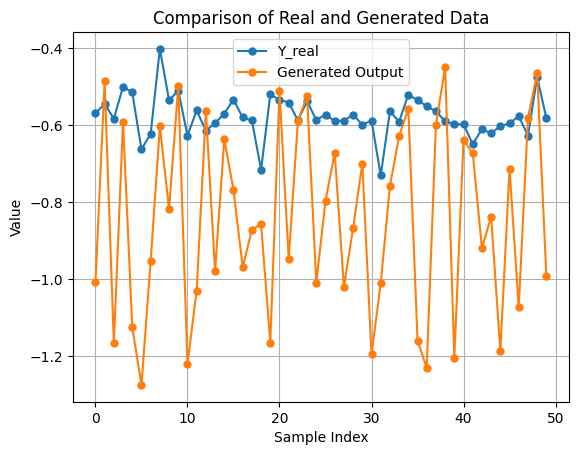

In [24]:
plt.plot(Y_real, 'o-', label='Y_real', markersize=5)
plt.plot(output[:, 0:1], 'o-', label='Generated Output', markersize=5)

# Labels and legend
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Comparison of Real and Generated Data")
plt.legend()
plt.grid(True)

plt.show()

This plot showing that till here without fine-tuning the data has captured the distribution quiet well.

## Evaluation

In [25]:
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity

def wasserstein_fidelity(y_real, y_fake):
    return wasserstein_distance(y_real.flatten(), y_fake.flatten())


def kl_divergence(y_real, y_fake):
    # Normalize to ensure they are probability distributions
    y_real = y_real / y_real.sum()
    y_fake = y_fake / y_fake.sum()

    return entropy(y_real, y_fake)  # KL Divergence


def compute_auc(y_real, y_fake):
    X = np.vstack([y_real, y_fake])  # Combine real and fake data
    y = np.hstack([np.ones(len(y_real)), np.zeros(len(y_fake))])  # Labels: 1 for real, 0 for fake

    clf = LogisticRegression()
    clf.fit(X, y)

    y_pred = clf.predict_proba(X)[:, 1]  # Get probability of being real
    return roc_auc_score(y, y_pred)


def mse_loss(y_real, y_fake):
    return F.mse_loss(y_real, y_fake)


def cosine_sim(y_real, y_fake):
    return cosine_similarity(y_real.reshape(1, -1), y_fake.reshape(1, -1))[0][0]



In [26]:
def evaluate_qgan(y_real, y_fake):
    y_real_np = y_real.detach().cpu().numpy() if isinstance(y_real, torch.Tensor) else y_real
    y_fake_np = y_fake.detach().cpu().numpy() if isinstance(y_fake, torch.Tensor) else y_fake

    results = {
        "KL Divergence": kl_divergence(y_real_np, y_fake_np),
        "Wasserstein Fidelity": wasserstein_fidelity(y_real_np, y_fake_np),
        "AUC-ROC": compute_auc(y_real_np, y_fake_np),
        "MSE": mse_loss(torch.tensor(y_real_np), torch.tensor(y_fake_np)).item(),
        "Cosine Similarity": cosine_sim(y_real_np, y_fake_np),
    }

    return results

In [27]:
evaluation_results = evaluate_qgan(Y_real, output[:, 0:1])
print(evaluation_results)


{'KL Divergence': array([0.04078283]), 'Wasserstein Fidelity': np.float64(0.26723456485518415), 'AUC-ROC': np.float64(0.8180000000000001), 'MSE': 0.12634068630080134, 'Cosine Similarity': np.float64(0.9631107109731133)}


## Fine-Tune with Correlation Penalty

In [28]:
# Custom Loss Function for Correlation Penalty
def correlation_penalty(y_fake, z):
    """Penalize if y_fake is too correlated with features from label 0."""
    corr_matrix = torch.corrcoef(torch.cat((y_fake, z), dim=1).T)  # Compute correlation
    corr_loss = torch.abs(corr_matrix[:y_fake.shape[1], -z.shape[1]:]).mean()  # Take mean of cross-correlations


    return corr_loss

In [29]:
def fine_tune_generator(model_gen, device, optimizer, z, epochs=30, lambda_corr=0.1, batch_size=10):
    for epoch in range(epochs):
        running_loss = 0.0
        y_fake_batch = []
        z_batch = []

        for i in range(len(z)):
            noise = torch.empty(2, dtype=torch.float32).uniform_(0.3, 0.9).to(device)
            y_fake = model_gen(noise)

            # Store multiple samples for batch correlation calculation
            y_fake_batch.append(y_fake.unsqueeze(0))
            z_batch.append(z[i].unsqueeze(0))

            if (i + 1) % batch_size == 0 or (i + 1) == len(z):  # Compute loss after batch_size samples
                y_fake_batch = torch.cat(y_fake_batch, dim=0)
                z_batch = torch.cat(z_batch, dim=0)

                optimizer.zero_grad()
                corr_loss = correlation_penalty(y_fake_batch, z_batch)
                loss = lambda_corr * corr_loss

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                y_fake_batch, z_batch = [], []  # Reset batch

        print(f'Fine-tuning Epoch {epoch + 1}: Corr Loss = {running_loss / (len(z) / batch_size):.6f}')


In [35]:
# Load pre-trained generator
model_gen.load_state_dict(torch.load('./GsoCiqgan_1.pth'))
optimizer_gen = optim.Adam(model_gen.parameters(), lr=0.001)

# Load z (should be a [50,4] tensor)
z = torch.tensor(Z_train, dtype=torch.float32).to(device)

fine_tune_generator(model_gen, device, optimizer_gen, z, epochs=50)
torch.save(model_gen.state_dict(), './qgan_finetuned.pth')


Fine-tuning Epoch 1: Corr Loss = 0.030857
Fine-tuning Epoch 2: Corr Loss = 0.029011
Fine-tuning Epoch 3: Corr Loss = 0.023686
Fine-tuning Epoch 4: Corr Loss = 0.026745
Fine-tuning Epoch 5: Corr Loss = 0.028392
Fine-tuning Epoch 6: Corr Loss = 0.027653
Fine-tuning Epoch 7: Corr Loss = 0.030654
Fine-tuning Epoch 8: Corr Loss = 0.019618
Fine-tuning Epoch 9: Corr Loss = 0.032555
Fine-tuning Epoch 10: Corr Loss = 0.024596
Fine-tuning Epoch 11: Corr Loss = 0.031334
Fine-tuning Epoch 12: Corr Loss = 0.034098
Fine-tuning Epoch 13: Corr Loss = 0.027088
Fine-tuning Epoch 14: Corr Loss = 0.030142
Fine-tuning Epoch 15: Corr Loss = 0.028451
Fine-tuning Epoch 16: Corr Loss = 0.021707
Fine-tuning Epoch 17: Corr Loss = 0.024000
Fine-tuning Epoch 18: Corr Loss = 0.032905
Fine-tuning Epoch 19: Corr Loss = 0.023592
Fine-tuning Epoch 20: Corr Loss = 0.023606
Fine-tuning Epoch 21: Corr Loss = 0.025907
Fine-tuning Epoch 22: Corr Loss = 0.031671
Fine-tuning Epoch 23: Corr Loss = 0.022687
Fine-tuning Epoch 24

In [36]:
model_gen.load_state_dict(torch.load('./qgan_finetuned.pth'))

def test(model, device):
    inputs = torch.empty((50, 2), dtype=torch.float32).uniform_(0.3,0.9)

    outputs = torch.rand((50, 2), device=device)
    for i in range(50):
        outputs[i] = model(inputs[i])*model(inputs[i])
    return outputs


output = test(model_gen, device).detach().numpy()
output = descale_sigmoid(output)

In [37]:
y_fake = output[:, 0:1]

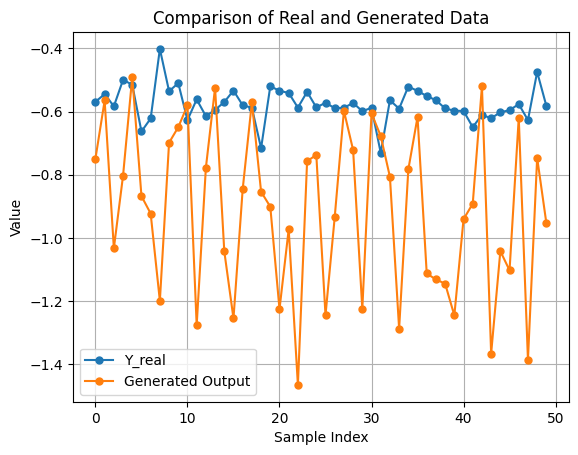

In [38]:
plt.plot(Y_real, 'o-', label='Y_real', markersize=5)
plt.plot(y_fake, 'o-', label='Generated Output', markersize=5)

# Labels and legend
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Comparison of Real and Generated Data")
plt.legend()
plt.grid(True)

plt.show()

In [39]:


evaluation_results = evaluate_qgan(Y_real, y_fake)
print(evaluation_results)


{'KL Divergence': array([0.04708707]), 'Wasserstein Fidelity': np.float64(0.3327350814213507), 'AUC-ROC': np.float64(0.892), 'MSE': 0.18237947089084056, 'Cosine Similarity': np.float64(0.9566538442182032)}
